In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from tqdm.auto import tqdm
import os 

model_names =        ['Llama3.2_1B', 'Llama3.1_8B',
                     'gemma-2-2b-it', 'gemma-2-9b-it',
                     'Phi-3.5-mini-instruct', 'Phi-3-medium-128k-instruct',
                     'OLMo-1B-hf', 'OLMo-7B-0724-Instruct-hf',
                     'Ministral-8B-Instruct-2410', 'Mistral-Nemo-Instruct-2407'
                     'OLMo-2-1124-7B-Instruct', 'OLMo-2-1124-13B-Instruct']
layers_counts = [16, 32, 
                 26, 42, 
                 32, 40,
                 16, 32,
                 36, 40,
                 32, 40]

model_name, layer_count = list(zip(model_names, layers_counts))[0]
layers = list(range(layer_count))

os.makedirs(f'figs/{model_name}', exist_ok=True)

FONT_SIZE = 16


c:\Users\kchun\Desktop\emo-llm\experiments\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os

os.listdir()

['gemma-2-2b-it', 'Llama3.2_1B', 'OLMo-1B-hf', 'Phi-3.5-mini-instruct']

In [4]:
%load_ext autoreload
%autoreload 2
from plotters_utils import *

import os
os.chdir('C:/Users/kchun/Desktop/emo-llm')

emotion_to_id, id_to_emotion, appraisals_to_id, id_to_appraisals, appraisal_to_formal_name, appraisal_to_formal_name_without_newline, appraisals, coefficients, biases, clean_logits, appraisal_labels = load_emotion_and_appraisals_list(model_name)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
save_prefix = ''
HOOK = True
if not HOOK:
    save_prefix = 'UNHOOKED_'

# Open Vocab Evaluation

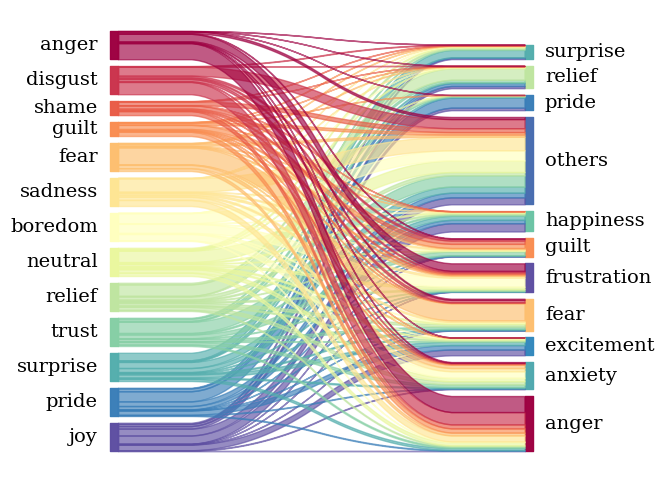

In [6]:
from copy import deepcopy

ground_truth, preds_model, filtered_preds = process_open_vocab(model_name, save_prefix, freq_threshold=10)


colorDict = deepcopy(emotion_to_color)
tab20_colors = get_discrete_colors(20, 'tab20')[::-1]

idx = 0
for emotion in filtered_preds:
    if emotion not in colorDict:
        colorDict[emotion] = tab20_colors[idx]
        idx += 1

        if idx >= 20:
            print('Not enough colors')
    
ground_truth, filtered_preds = sort_two_emotion_lists_based_on_the_first_one(ground_truth, filtered_preds, emotions_formal)

plot_sankey(ground_truth, filtered_preds, aspect = 10, fontsize=14, colorDict = colorDict, save_path=f'{model_name}/open_vocab_result', title = '') #Open Vocab Results

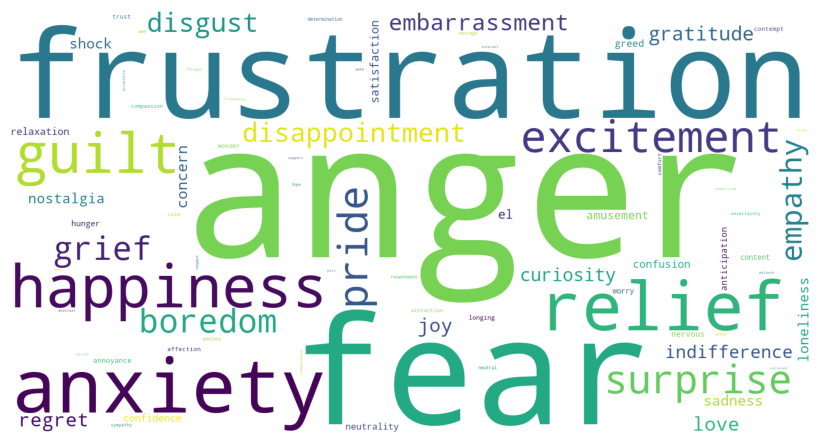

In [7]:
plot_wordcloud(list_of_words = preds_model, save_path = f'{model_name}/wordcloud', min_font_size=5)

# LLM Predictions before Filtering the Dataset

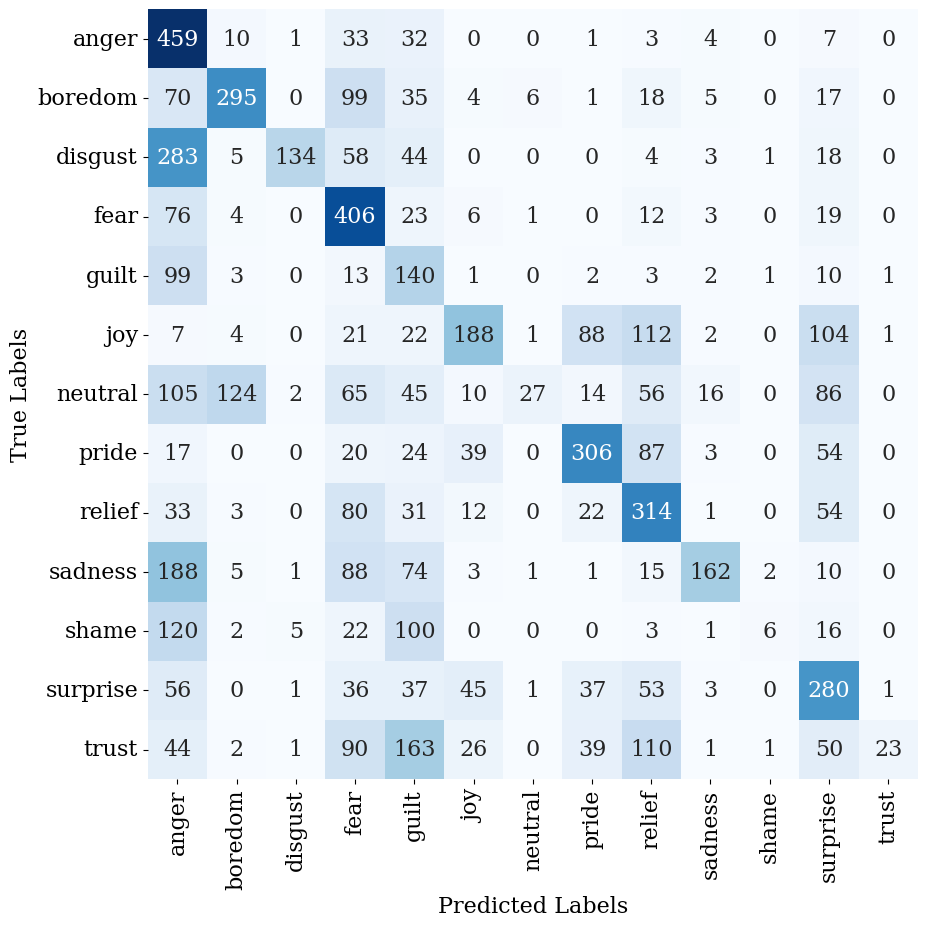

Accuracy: 0.41515151515151516 Total: 6600 Correct: 2740


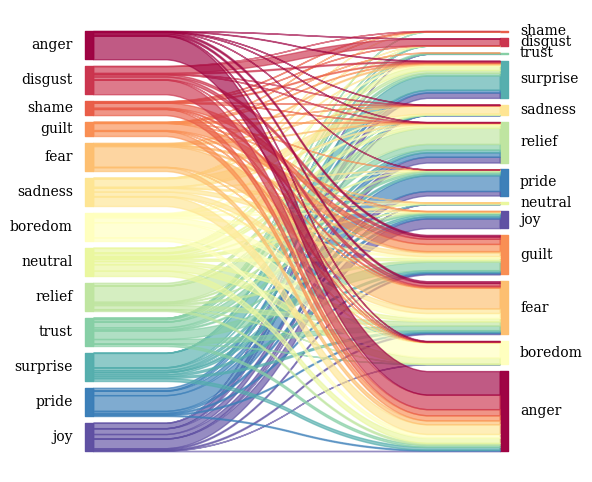

In [8]:
labels_predicted_, labels_true_ = torch.load(f'outputs/{model_name}/{save_prefix}unfiltered_emotion_logits.pt', weights_only=False)
plot_confusion_matrix(labels_true_, labels_predicted_, save_prefix=save_prefix, emotion_to_id=emotion_to_id, save_path=f'{model_name}/confusion_matrix', fontsize=FONT_SIZE, figsize=(10,10))
labels_predicted = [id_to_emotion[label.item()] for label in labels_predicted_]
labels_true = [id_to_emotion[label.item()] for label in labels_true_]

labels_true, labels_predicted = sort_two_emotion_lists_based_on_the_first_one(labels_true, labels_predicted, emotions_formal)
plot_sankey(labels_true, labels_predicted, aspect = 10, fontsize=10, colorDict = emotion_to_color, save_path=f'{model_name}/in_domain_result', title = '')


# Appraisals Radar Plot

torch.Size([6, 6])


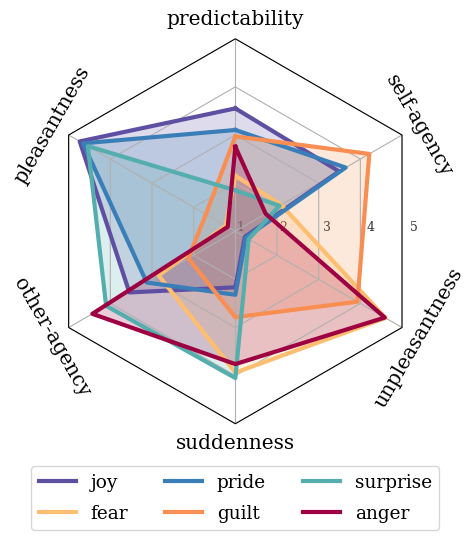

In [9]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

emotion_labels = clean_logits.argmax(dim=1)

emotions_to_plot = ['joy', 'fear', 'pride', 'guilt', 'surprise', 'anger']
appraisals_to_plot = ['predict_event', 'pleasantness', 'other_responsblt', 'suddenness', 'unpleasantness', 'self_responsblt']

values = torch.tensor([[appraisal_labels[emotion_labels == emotion_to_id[e], appraisals_to_id[a]].to(torch.float32).mean().item() for a in appraisals_to_plot] for e in emotions_to_plot])

print(values.shape)

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)
        
        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

theta = radar_factory(len(appraisals_to_plot), frame='polygon')

fig, axs = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection='radar'))

colors = [emotion_to_color[e] for e in emotions_to_plot]
fig.canvas.draw()

for i, (d, color) in enumerate (zip(values, colors)):
    axs.plot(theta, d, color=color, label = emotions_to_plot[i], linewidth=3)
    axs.fill(theta, d, facecolor=color, alpha=0.2)

axs.set_ylim(1, 5)
axs.set_rgrids([1, 2, 3, 4, 5], labels=["", "", "", "", ""], fontsize=FONT_SIZE / 1.8, 
               color='gray', alpha=1, zorder=0, 
               verticalalignment='bottom', horizontalalignment='center', angle = 270)

for i in range(1, 6):
    # print((4.6 - 1) / (5 - 1) * i + 0.4 / 4)
    axs.text(-3.14/2, (4.6 - 1) / (5 - 1) * i + 0.4 / 4 + 0.02, str(i), fontsize=FONT_SIZE / 1.8, color='black', alpha=.8, zorder=-1,)


xticks_labels = [appraisal_to_formal_name_without_newline[a] for a in appraisals_to_plot]
leg = axs.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), labelspacing=.7, ncols=3, fontsize=FONT_SIZE / 1.2)
for line in leg.get_lines():
    line.set_linewidth(3.0)

axs.set_varlabels(xticks_labels)


angles = np.linspace(0,2*np.pi,len(axs.get_xticklabels())+1)
angles[np.cos(angles) < 0] = angles[np.cos(angles) < 0] + np.pi
angles = np.rad2deg(angles)

for label, angle in zip(axs.get_xticklabels(), angles):
    x,y = label.get_position()
    lab = axs.text(x,y, label.get_text(), transform=label.get_transform(),
                  ha=label.get_ha(), va=label.get_va(), fontsize=FONT_SIZE / 1.1)
    lab.set_rotation(angle)
    
axs.set_xticklabels([' ' for _ in range(len(theta))])

plt.savefig(f'figs/{model_name}/appraisal_emo_mappings.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Emotion Probing

In [10]:
# emotion probe
locs_to_probe = [3, 6, 7]
tokens = list(range(-1, -6, -1)) #[-1] #
emotion_probe_results = process_emotion_probe_results(model_name, layers, locs_to_probe, tokens)
values = emotion_probe_results[:, tokens.index(-1)].unsqueeze(0)

plot_bars(values, figsize = (6, 4),
          labels = [f'{probe_location_to_formal_name[i]}' for i in locs_to_probe],
          xticklabels=[f'{i + 1}' for i in layers],
          bar_width = bar_width,
          fontsize = FONT_SIZE,
          titles=[''],
          suptitle='', #Probing Emotion Accuracy at \n Different Layers (Last Token)
          xlabel = 'Layers',
          ylabel= 'Held-out \n test accuracy',
          y_low = 0.0, y_high = 1.0,
          save_path=f'{model_name}/emotion_probe_last_token'
          )

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/Llama3.2_1B/emotion_probing_layers_[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]_locs_[3, 6, 7]_tokens_[-1, -2, -3, -4, -5].pt'

In [11]:
plot_heatmap(emotion_probe_results.flip(1),
             suptitle = '', titles = [f'{probe_location_to_formal_name[loc]}' for loc in locs_to_probe], fontsize = 12,
             xticks = np.arange(len(layers)) + 0.5, xtick_labels = (torch.tensor(layers) + 1).numpy(),
             yticks = np.arange(len(tokens)) + 0.5, ytick_labels = tokens[::-1],
             yticks_rotation = 90, xticks_rotation = 0,
             vmax=1.0, vmin=0.0,
             x_axis_label='Layers', y_axis_label='Tokens',
             cmap='magma', cmap_label='Accuracy', cmap_shrink=1.0, cmap_aspect=10.0, cmap_fraction=0.01, cmap_pad=0.01,
             cbar_yticks=[0, 0.9], cbar_ytick_labels=[0, 1],
             figsize=(20, 3), save_path = f'{model_name}/emotion_probe_heatmap')

NameError: name 'emotion_probe_results' is not defined

# Non-Linear Emotion Probing

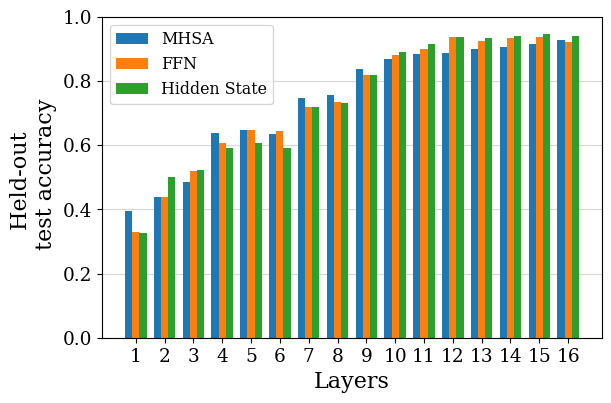

In [12]:
# emotion probe
locs_to_probe = [3, 6, 7]
tokens = [-1] #list(range(-1, -6, -1)) #
emotion_probe_results = process_non_linear_emotion_probe_results(model_name, layers, locs_to_probe, tokens)
values = emotion_probe_results[:, tokens.index(-1)].unsqueeze(0)

plot_bars(values, figsize = (6, 4),
          labels = [f'{probe_location_to_formal_name[i]}' for i in locs_to_probe],
          xticklabels=[f'{i + 1}' for i in layers],
          bar_width = bar_width,
          fontsize = FONT_SIZE,
          titles=[''],
          suptitle='', #Probing Emotion Accuracy at \n Different Layers (Last Token)
          xlabel = 'Layers',
          ylabel= 'Held-out \n test accuracy',
          y_low = 0.0, y_high = 1.0,
          save_path=f'{model_name}/non_linear_emotion_probe_last_token'
          )

# Zero Intervention Results

In [11]:
locs_to_probe = [3, 6, 7]
span = 1
layers_centers = list(range(span // 2, layer_count - span // 2))
tokens = [[-1], [-2], [-3], [-4], [-5], 'all'] #[[-1]] #

zero_intervention_values = process_zero_intervention(model_name, locs_to_probe, tokens, layers_centers, span)
values = zero_intervention_values[:, tokens.index([-1])]

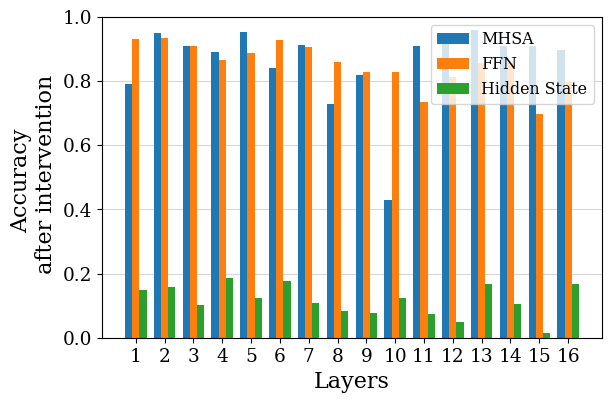

In [12]:
plot_bars(values.unsqueeze(0), figsize = (6, 4),
          labels = [f'{probe_location_to_formal_name[i]}' for i in locs_to_probe],
          xticklabels=[f'{i + 1}' for i in layers_centers],
          bar_width = bar_width,
          fontsize = FONT_SIZE,
          suptitle='', #Zero Intervention Effect at \n Different Layers (Last Token)
          titles = [''],
          xlabel = 'Layers',
          ylabel= 'Accuracy \n after intervention',
          y_low = 0.0, y_high=1.0,
          save_path=f'{model_name}/zero_intervention_last_token_span_{span}'
          )




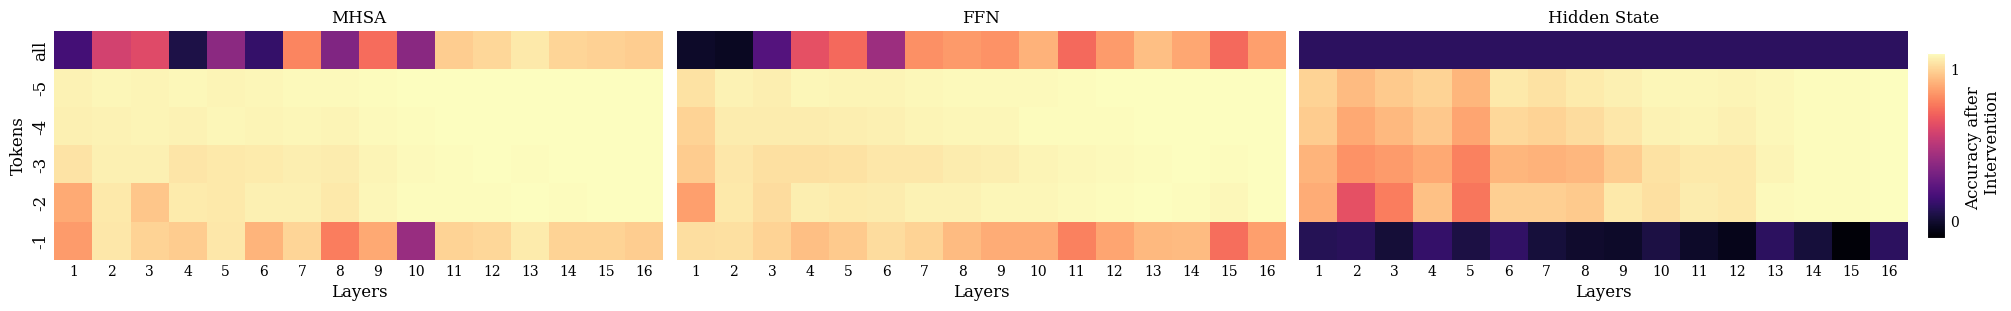

In [13]:
tokens_ = [t[0] if isinstance(t, list) else t for t in tokens[::-1]]

plot_heatmap(zero_intervention_values.flip(1),
             suptitle = f'', titles = [f'{probe_location_to_formal_name[loc]}' for loc in locs_to_probe], fontsize = 12,
             xticks = np.arange(len(layers_centers)) + 0.5, xtick_labels = (torch.tensor(layers_centers) + 1).numpy(),
             yticks = np.arange(len(tokens_)) + 0.5, ytick_labels = tokens_,
             yticks_rotation = 90, xticks_rotation = 0,
             vmax=1.0, vmin=0.0,
             x_axis_label='Layers', y_axis_label='Tokens',
             cmap='magma', cmap_label='Accuracy after \n Intervention', cmap_shrink=1.0, cmap_aspect=10.0, cmap_fraction=0.01, cmap_pad=0.01,
             cbar_yticks=[0, 0.9], cbar_ytick_labels=[0, 1],
             figsize=(20, 3), save_path = f'{model_name}/zero_intervention_span_{span}')

# Random Intervention Results

In [14]:
locs_to_probe = [3, 6, 7]
span = 1
seed = 100
layers_centers = list(range(span // 2, layer_count - span // 2))
tokens = [[-1], [-2], [-3], [-4], [-5], 'all'] #[[-1]] #

random_intervention_values = process_random_intervention(model_name, locs_to_probe, tokens, layers_centers, span, seed)
values = random_intervention_values[:, tokens.index([-1])]

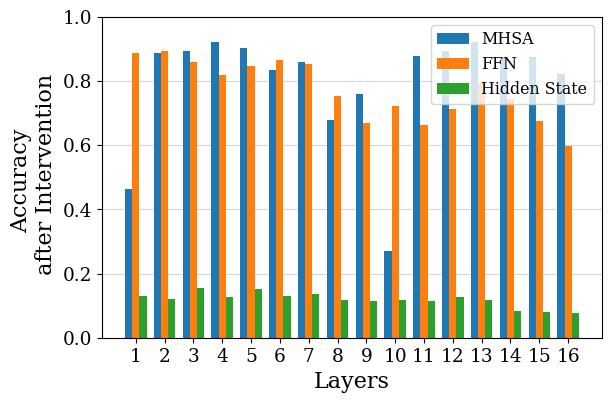

In [15]:
plot_bars(values.unsqueeze(0), figsize = (6, 4),
          labels = [f'{probe_location_to_formal_name[i]}' for i in locs_to_probe],
          xticklabels=[f'{i + 1}' for i in layers_centers],
          bar_width = bar_width,
          fontsize = FONT_SIZE,
          suptitle='', #Random Intervention Effect at \n Different Layers (Last Token)
          titles = [''],
          xlabel = 'Layers',
          ylabel= 'Accuracy \n after Intervention',
          y_low = 0.0, y_high=1.0,
          save_path=f'{model_name}/random_intervention_last_token_span_{span}'
          )




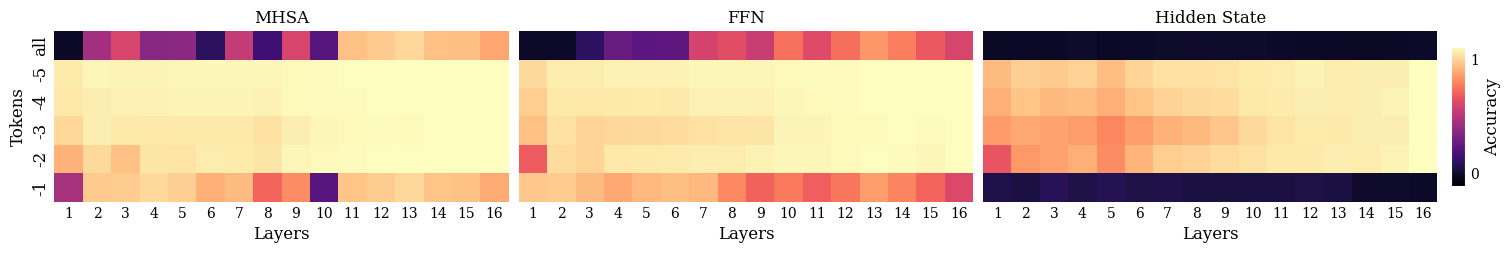

In [16]:
tokens_ = [t[0] if isinstance(t, list) else t for t in tokens[::-1]]

plot_heatmap(random_intervention_values.flip(1),
             suptitle = f'', titles = [f'{probe_location_to_formal_name[loc]}' for loc in locs_to_probe], fontsize = 12,
             xticks = np.arange(len(layers_centers)) + 0.5, xtick_labels = (torch.tensor(layers_centers) + 1).numpy(),
             yticks = np.arange(len(tokens_)) + 0.5, ytick_labels = tokens_,
             yticks_rotation = 90, xticks_rotation = 0,
             vmax=1.0, vmin=0.0,
             x_axis_label='Layers', y_axis_label='Tokens',
             cmap='magma', cmap_label='Accuracy', cmap_shrink=1.0, cmap_aspect=10.0, cmap_fraction=0.01, cmap_pad=0.01,
             cbar_yticks=[0, 0.9], cbar_ytick_labels=[0, 1],
             figsize=(15, 3), save_path = f'{model_name}/random_intervention_span_{span}')

# Emotion Transfer using Patching

In [17]:
num_exps = 200
span = 3
tokens = list(range(-1, -6, -1)) # [-1] # 
locs_to_probe = [3, 6, 7]
layers_centers = list(range(span // 2, layer_count - span // 2))
activation_patching_results = process_activation_patching(model_name, num_exps, locs_to_probe, tokens, layers_centers, span)

  0%|          | 0/3 [00:00<?, ?it/s]

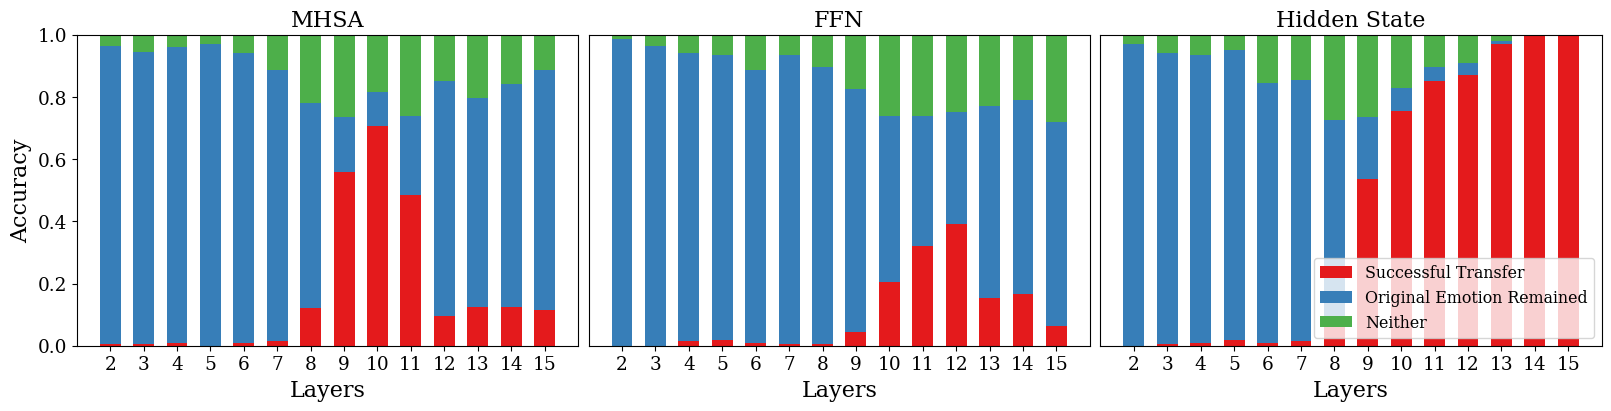

In [18]:
plot_cumulative_bar(activation_patching_results[:, tokens.index(-1)],
                    titles = [f'{probe_location_to_formal_name[l]}' for l in locs_to_probe],
                    bar_width = bar_width * 2.5, figsize = (16, 4), fontsize = FONT_SIZE,
                    xtick_labels_ = [np.array(layers_centers) + 1] * len(locs_to_probe),
                    x_low=1.0, x_high=16.0, y_low = 0.0, y_high = 1.0, colors = sns.color_palette("Set1"),
                    labels = ["Successful Transfer", "Original Emotion Remained", "Neither"], 
                    legend_loc = 'lower right', legend_index = 2,
                    save_path = f'{model_name}/activation_patching_{span}')


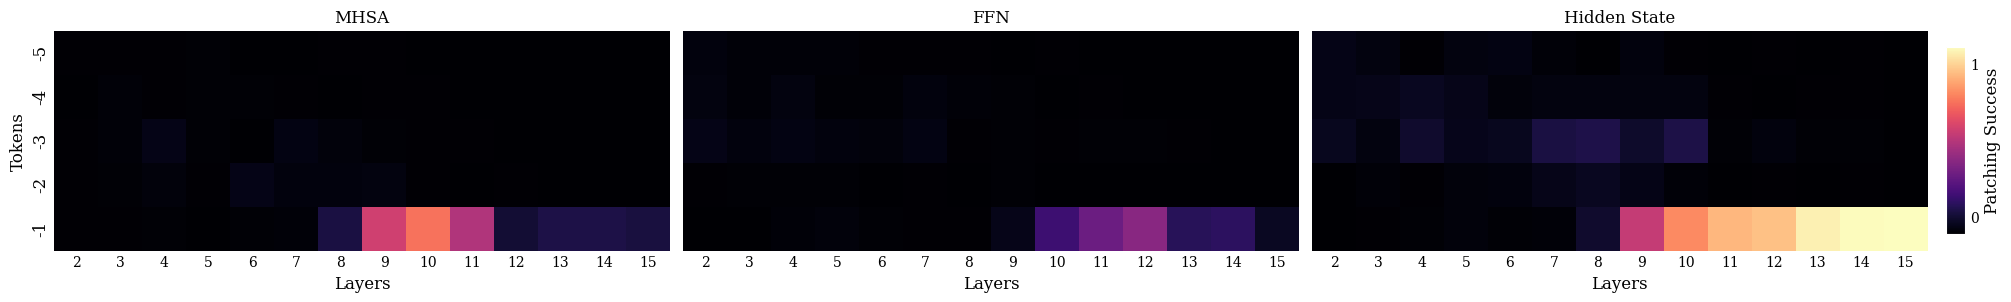

In [19]:
plot_heatmap(activation_patching_results[..., 0].flip(1),
             suptitle = f'', titles = [f'{probe_location_to_formal_name[loc]}' for loc in locs_to_probe], fontsize = 12,
             xticks = np.arange(len(layers_centers)) + 0.5, xtick_labels = (torch.tensor(layers_centers) + 1).numpy(),
             yticks = np.arange(len(tokens)) + 0.5, ytick_labels = tokens[::-1],
             yticks_rotation = 90, xticks_rotation = 0,
             vmax=1.0, vmin=0.0,
             x_axis_label='Layers', y_axis_label='Tokens',
             cmap='magma', cmap_label='Patching Success', cmap_shrink=1.0, cmap_aspect=10.0, cmap_fraction=0.01, cmap_pad=0.01,
             cbar_yticks=[0, 0.9], cbar_ytick_labels=[0, 1],
             figsize=(20, 3), save_path = f'{model_name}/activation_patching_span_{span}')


# Span Size

In [20]:
num_exps = 200
tokens = [-1] # list(range(-1, -6, -1)) # 
locs_to_probe = [3, 6, 7]
loc_to_plot = 3
spans = [1, 3, 5]
layers_centers_spans = []
activation_patching_results_spans = []

for span in spans:
    layers_centers = list(range(span // 2, layer_count - span // 2))
    a = process_activation_patching(model_name, num_exps, locs_to_probe, tokens, layers_centers, span)
    a = a[locs_to_probe.index(loc_to_plot), tokens.index(-1)]
    layers_centers_spans.append(np.array(layers_centers) + 1)
    activation_patching_results_spans.append(a)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

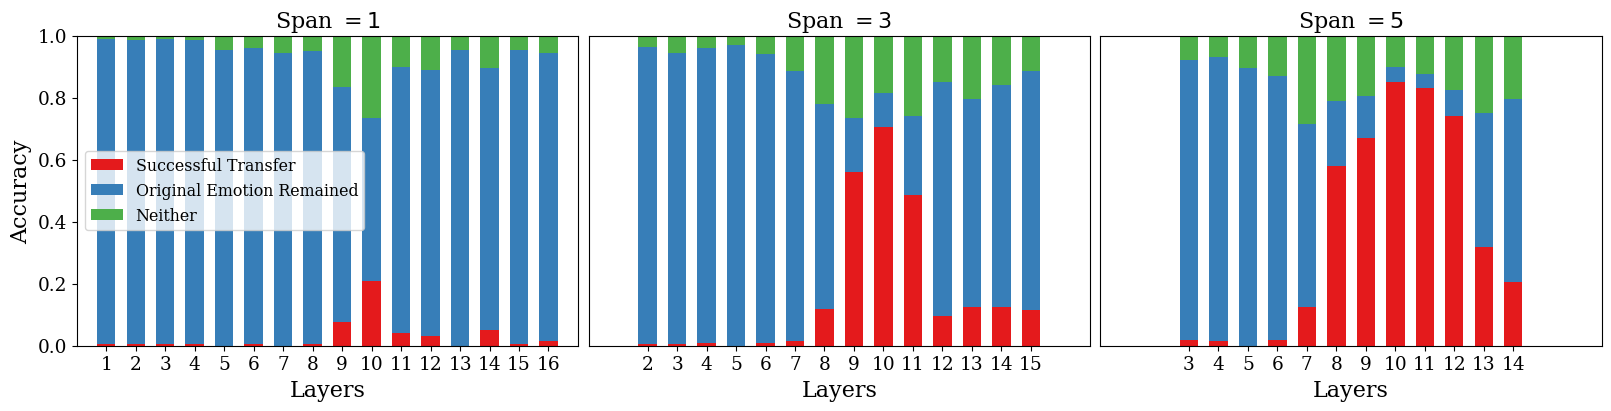

In [21]:


plot_cumulative_bar(activation_patching_results_spans,
                    titles = [f'Span $ = {span}$' for span in spans],
                    bar_width = bar_width * 2.5, figsize = (16, 4), fontsize = FONT_SIZE,
                    xtick_labels_ = layers_centers_spans,
                    x_low=0.0, x_high=17.0, y_low = 0.0, y_high = 1.0, colors = sns.color_palette("Set1"),
                    labels = ["Successful Transfer", "Original Emotion Remained", "Neither"], 
                    legend_loc = 'center left', legend_index = 0,
                    save_path = f'{model_name}/activation_patching_all_spans_{probe_location_to_formal_name[loc_to_plot]}')    


# Studying Attentions

In [22]:
extraction_locs = [10]
extraction_tokens = [-1]

results = torch.load(f'outputs/{model_name}/attention_weights_layers_{layers}_locs_{extraction_locs}_tokens_{extraction_tokens}.pt', weights_only=False)
attn_weights, tokenized_text = results
original_logits = torch.load(f'outputs/{model_name}/original_logits.pt', weights_only=False)

attn_weights[0].shape
num_heads = attn_weights[0].shape[3]


In [23]:
top_k = 1
layer_to_words = {i: [] for i in range(layer_count)}
all_texts = []
for idx, text in tqdm(enumerate(tokenized_text), total = len(tokenized_text)):
    text = [t.replace('Ġ', '_') for t in text]
    templ_list = [      ( 0, 13, '<0>'),
                        (13, 19, '<1>'),
                        (19, 21, '<0>'),
                        (21, 22, '<1>'),
                        (22, 24, '<0>'),
                        (24, 30, '<2>'),
                        (30, 32, '<0>'),
                        (32, 33, '<2>'),
                        (33, 35, '<3>'),
                        (35, -2, '<4>'),
                        (-2, None, '<3>'),
                        ]
    
    text = [[t[2] + j for j in text[t[0]:t[1]]] for t in templ_list]
    text = [item for sublist in text for item in sublist]
    
    # assert False
    logit = original_logits[idx]
    emotion = id_to_emotion[logit.argmax().item()]
    att_w = attn_weights[idx][0, :, 0, :, 0]
    
    text = text[1:]
    att_w = att_w[:, :, 1:].clone()
    indices = torch.arange(len(text)).unsqueeze(0).unsqueeze(0).expand(att_w.shape)
    att_w = att_w.reshape(layer_count, -1)
    indices = indices.reshape(layer_count, -1)
    # print(indices.shape)
    att_w_top_k_indices = att_w.topk(top_k, dim=1).indices
    
    all_texts.append(text)
    
    for l in range(layer_count):
        for t in att_w_top_k_indices[l]:
            word = text[indices[l, t]]
            layer_to_words[l].append(word)

for l in range(layer_count):
    words = layer_to_words[l]
    # sort by frequency
    words, counts = np.unique(words, return_counts=True)
    sorted_indices = np.argsort(-counts)
    words = words[sorted_indices]
    counts = counts[sorted_indices]
    word_counts = list(zip(words, counts))
    print(f'Layer {l + 1} attention words:', word_counts)
    layer_to_words[l] = word_counts
        
    

  0%|          | 0/2740 [00:00<?, ?it/s]

Layer 1 attention words: [('<3>_Answer', 2739), ('<4>).', 1)]
Layer 2 attention words: [('<3>_Answer', 2665), ('<0>:', 74), ('<3>:', 1)]
Layer 3 attention words: [('<1>_joy', 1092), ('<3>_Answer', 840), ('<3>:', 797), ('<2>_sadness', 10), ('<4>_...', 1)]
Layer 4 attention words: [('<3>_Answer', 2738), ('<4>_When', 1), ('<4>_while', 1)]
Layer 5 attention words: [('<3>_Answer', 1171), ('<0>:', 1074), ('<0>?', 493), ('<3>:', 2)]
Layer 6 attention words: [('<1>_joy', 1721), ('<4>_...', 394), ('<3>_Answer', 278), ('<0>_Context', 181), ('<0>_emotions', 128), ('<4>_....', 33), ('<0>:', 4), ('<3>_Context', 1)]
Layer 7 attention words: [('<3>_Answer', 2111), ('<0>:', 466), ('<0>_emotions', 61), ('<4>_...', 50), ('<4>_....', 22), ('<3>:', 19), ('<2>_sadness', 9), ('<4>_...,', 2)]
Layer 8 attention words: [('<2>_sadness', 2668), ('<3>_Answer', 36), ('<4>_....', 15), ('<1>_joy', 10), ('<4>_...', 7), ('<0>_Context', 1), ('<3>:', 1), ('<4>.', 1), ('<4>_', 1)]
Layer 9 attention words: [('<3>_Answer',

In [24]:
min_val = 1

for l in range(layer_count):
    layer_to_words[l] = [(w, c) for w, c in layer_to_words[l] if c >= min_val]


top_keeps = 15
for l in range(layer_count):
    if len(layer_to_words[l]) > top_keeps:
        others_sum = sum([c for w, c in layer_to_words[l][top_keeps:]])
        layer_to_words[l] = layer_to_words[l][:top_keeps]
        layer_to_words[l].append(('other', others_sum))
    

colors = sns.color_palette("tab10", 10)

In [25]:
# Function to create an RGB ANSI escape sequence
def rgb_text(r, g, b, text):
    if isinstance(r, float):
        r = int(r*255)
        g = int(g*255)
        b = int(b*255)   
    
    return f"\033[48;2;{r};{g};{b}m{text}\033[0m"

text = all_texts[654]
colored_text = []
for i, word in enumerate(text):
    tag = int(word.split('>')[0][1:])
    word = word.split('>')[1]
    # print(colors[tag][0]* 255, colors[tag][1]* 255, colors[tag][2]* 255)
    r, g, b = colors[tag]  # Cycle through colors
    colored_text.append(rgb_text(r, g, b, word))

title1 = ''.join(colored_text[:len(colored_text) // 2])
title2 = ''.join(colored_text[len(colored_text) // 2:])
print(title1)
print(title2)


What_are_the_inferred_emotions_in_the_following_contexts?_Context:_My_first_child_was_born._Answer:_joy_Context:_My
_dog_died_last_week._Answer:_sadness_Context:_the_last_time_i_worked_from_home_with_no_real_work_to_complete_Answer:


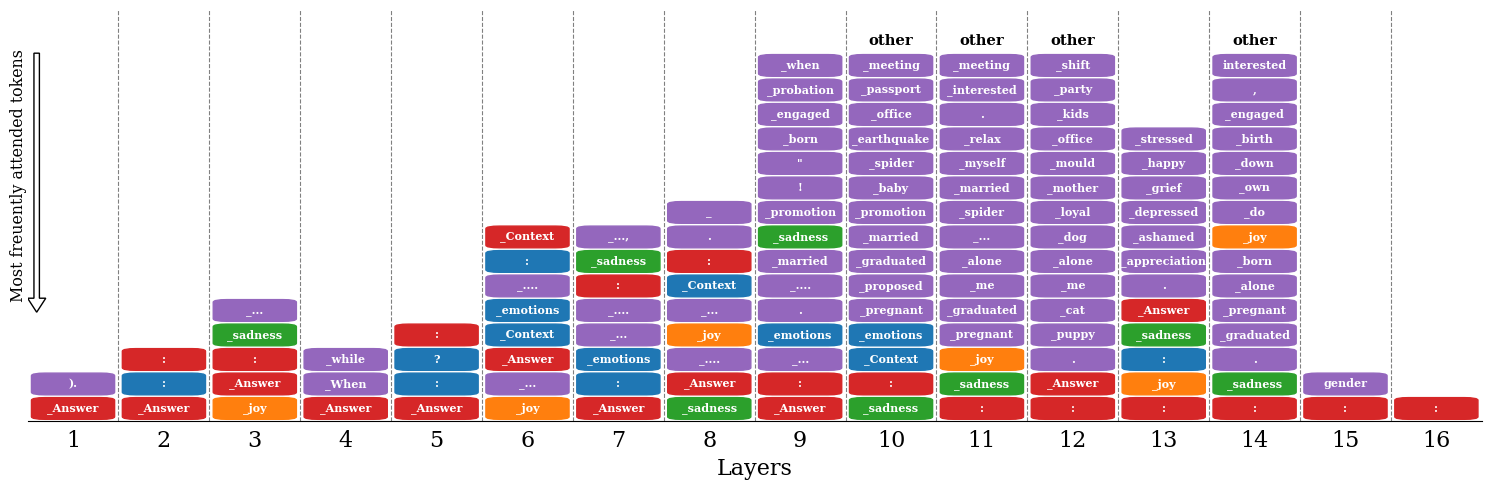

In [26]:
import matplotlib.patches as patches
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

bar_height = 1.4

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(15, 5))
x = np.arange(layer_count)



for layer in range(layer_count):
    for i, (word, count) in enumerate(layer_to_words[layer]):
        if word != 'other':            
            # set color_bar to light gray
            tag = int(word.split('>')[0][1:])
            word = word.split('>')[1]
            
            fs = FONT_SIZE / 2.0
            
            # if 6 <= len(word) <= 9:
            #     fs = FONT_SIZE / 2.0
            # elif len(word) > 9:
            #     fs = FONT_SIZE / 2.5
            
            # print(word, ':', len(word), fs)
            
            bar = ax.bar(layer, bar_height - 0.05, bottom = i * bar_height, width=bar_width * 3.5, color = 'white')[0]
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + bar_height/2, f'{word}', ha='center', va='center', fontsize=fs, color='white', fontweight='bold') # #:{count}
            
            rounded_rect = patches.FancyBboxPatch(
            (layer - bar.get_width()/2, i * bar_height + 0.1),  # (x, y)
            bar.get_width(),  # Width
            bar_height - 0.2,  # Height
            boxstyle="round,pad=0.02,rounding_size=0.15",  # Rounded box style
            color=colors[tag],  # Color of the box
            edgecolor="black"  # Bar edge color
            )
            ax.add_patch(rounded_rect)
        else:
            bar = ax.bar(layer, bar_height - 0.05, bottom = i * bar_height, width=bar_width * 3.5, color = 'white')[0]
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + bar_height/2, f'{word}', ha='center', va='center', fontsize=FONT_SIZE/1.5, color='black', fontweight='bold')

# draw vertical lines
for i in range(1, layer_count):
    start = i - 0.5
    ax.axvline(start, color='gray', lw=0.8, ls='--')

ax.yaxis.set_visible(False)
ax.tick_params(axis='x', bottom=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.set_xticks(x)
ax.set_xticklabels(x+1, rotation=0, ha='center', fontsize=FONT_SIZE)
ax.set_xlim(-0.5, layer_count - 0.5)
ax.set_xlabel('Layers', fontsize=FONT_SIZE)

# Draw the arrow
ax.arrow(-0.4, 21.0, 0, -14.0, head_width=0.2, head_length=0.8, fc='white', ec='black', width=0.06)

# Add the text
ax.text(-0.6, 14, 'Most freuently attended tokens', fontsize=FONT_SIZE / 1.4, rotation=90, va='center', ha='center')


# ax.text(0.5, 1.05, title, ha='center', va='center', fontsize=FONT_SIZE + 2, fontweight='bold', transform=ax.transAxes)
plt.tight_layout()
plt.savefig(f'figs/{model_name}/attention_words.pdf', dpi=300, bbox_inches='tight')

# Appraisal Probing

torch.Size([20, 1, 3, 16])
torch.Size([20, 3, 16])


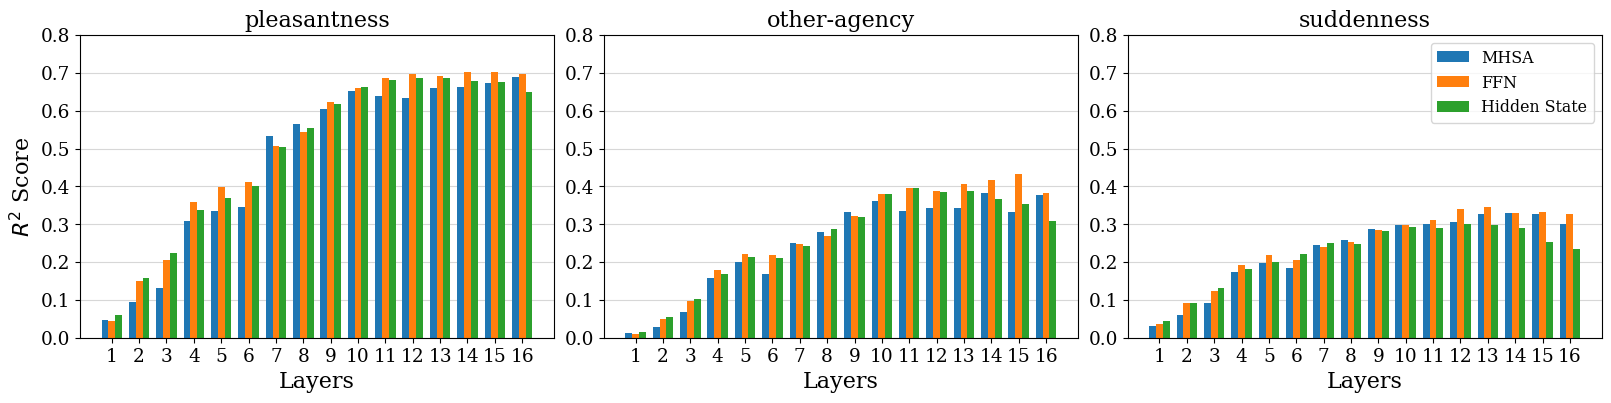

In [27]:
# appraisal Probe
locs_to_probe = [3, 6, 7]
tokens = [-1] #list(range(-1, -6, -1))

data = torch.load (f'outputs/{model_name}/appraisal_probing_layers_{layers}_locs_{locs_to_probe}_tokens_{tokens}.pt', weights_only=False)

appraisal_results = [[[[data[app][l][i][token_to_pick]['r2_test'] for l in range(layer_count)] for i in locs_to_probe] for token_to_pick in tokens] for app in appraisals]
appraisal_results = torch.tensor(appraisal_results)

print(appraisal_results.shape)

values = appraisal_results[:, tokens.index(-1)]
print(values.shape)

appraisals_to_plot_part1 = ['pleasantness', 'other_responsblt', 'suddenness',]
appraisals_to_plot_part2 = ['unpleasantness', 'self_responsblt', 'predict_event']

part = 1
appraisals_to_plot = appraisals_to_plot_part1 if part == 1 else appraisals_to_plot_part2

values = values[[appraisals_to_id[a] for a in appraisals_to_plot]]

plot_bars(values, figsize = (16, 4),
          labels = [f'{probe_location_to_formal_name[i]}' for i in locs_to_probe],
          xticklabels=[f'{i + 1}' for i in layers],
          bar_width = bar_width,
          fontsize = FONT_SIZE,
          titles=[appraisal_to_formal_name_without_newline[app] for app in appraisals_to_plot],
          suptitle='', #Probing appraisals at \n different layers (Last Token)
          xlabel = 'Layers',
          ylabel= '$R^2$ Score',
          y_low = 0, y_high = 0.8,
          activate_legend = part == 1,
          save_path=f'{model_name}/appraisal_probe_last_token_part_{part}'
          )

# Scatter Plots

In [28]:
appraisal_weights = torch.load(f'outputs/{model_name}/appraisals_weights_layers_{layers}_locs_{locs_to_probe}_tokens_{tokens}.pt', weights_only=False)
appraisal_biases = torch.load(f'outputs/{model_name}/appraisals_biases_layers_{layers}_locs_{locs_to_probe}_tokens_{tokens}.pt', weights_only=False)
emotion_weights = torch.load(f'outputs/{model_name}/emotions_weights_layers_{layers}_locs_{locs_to_probe}_tokens_{tokens}.pt', weights_only=False)
emotion_biases = torch.load(f'outputs/{model_name}/emotions_biases_layers_{layers}_locs_{locs_to_probe}_tokens_{tokens}.pt', weights_only=False)
print(emotion_weights.shape, appraisal_weights.shape)
appraisal_weights = appraisal_weights / appraisal_weights.norm(dim=-1, keepdim=True) # shape: [num_appraisals, num_layers, num_locs, num_tokens, hidden_size]
emotion_weights = emotion_weights / emotion_weights.norm(dim=-1, keepdim=True) # shape: [num_emotions, num_layers, num_locs, num_tokens, hidden_size]
appraisal_weights = appraisal_weights[..., tokens.index(-1), :] # shape: [num_appraisals, num_layers, num_locs, hidden_size]
emotion_weights = emotion_weights[..., tokens.index(-1), :] # shape: [num_emotions, num_layers, num_locs, hidden_size]

emotion_weights = emotion_weights.permute(2, 1, 0, 3)
appraisal_weights = appraisal_weights.permute(2, 1, 0, 3)

emotion_app_scores = generate_correlation_heatmap(emotion_weights, appraisal_weights)

torch.Size([13, 16, 3, 1, 2048]) torch.Size([20, 16, 3, 1, 2048])


torch.Size([16, 2, 2048]) torch.Size([16, 6, 2048])
torch.Size([16, 6, 2])


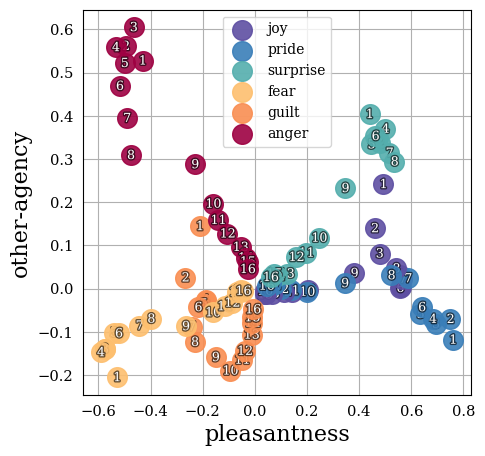

In [29]:
import matplotlib.patheffects as path_effects

loc_to_focus = 7

appraisals_to_focus = ['pleasantness', 'other_responsblt']
# appraisals_to_focus = ['pleasantness', 'suddenness']
# appraisals_to_focus = ['chance_control', 'pleasantness']
assert len(appraisals_to_focus) == 2, 'Only two appraisals are supported'

app = appraisal_weights[:, :, [appraisals_to_id[a] for a in appraisals_to_focus]]
app = app[locs_to_probe.index(loc_to_focus)]


emotions_to_focus = ['joy', 'pride', 'surprise', 'fear', 'guilt', 'anger']
emo = emotion_weights[:, :, [emotion_to_id[e] for e in emotions_to_focus]]
emo = emo[locs_to_probe.index(loc_to_focus)]
print(app.shape, emo.shape)

w = torch.einsum('bcd,bed->bce', emo, app)

plt.figure(figsize=(5, 5))
alphas = np.linspace(0.1, 1, layer_count)[::-1]
print(w.shape)
zorder = 0
for i, l in enumerate(range(0, layer_count)):
    for q, e in enumerate(emotions_to_focus):
        if i == 0:
            label = e
        else:
            label = None
        plt.scatter(w[l, emotions_to_focus.index(e), 0], w[l, emotions_to_focus.index(e), 1], c=emotion_to_color[e], alpha=.9, s=200, label=label, zorder=zorder)
        text_color = 'white'
        zorder += 1
        # plot text with glow and bold
        text = plt.text(w[l, emotions_to_focus.index(e), 0] + .0009, w[l, emotions_to_focus.index(e), 1] - .0009, f'{l+1}', fontsize=9, ha='center', va='center', color=text_color, zorder=zorder)
        glow_effect = path_effects.withStroke(linewidth=2.0, foreground='black', alpha=0.6)
        text.set_path_effects([glow_effect])
        
        
        zorder += 1

plt.legend()
plt.xlabel(f'{appraisal_to_formal_name_without_newline[appraisals_to_focus[0]]}', fontsize=FONT_SIZE)
plt.ylabel(f'{appraisal_to_formal_name_without_newline[appraisals_to_focus[1]]}', fontsize=FONT_SIZE)
# plt.title(f'Projection of Emotions to Appraisals at {probe_location_to_formal_name[loc_to_focus]}')  
# set fontsize of the axis
plt.xticks(fontsize=FONT_SIZE/1.5)
plt.yticks(fontsize=FONT_SIZE/1.5)
plt.tick_params(left=False, bottom=False)
plt.grid(True)
ax = plt.gca()
ax.set_axisbelow(True)
plt.savefig(f'figs/{model_name}/emotion_to_appraisal_projection_{loc_to_focus}.pdf', bbox_inches='tight', dpi = 300)
plt.show()

torch.Size([16, 3, 2048]) torch.Size([16, 6, 2048])
torch.Size([16, 6, 3])


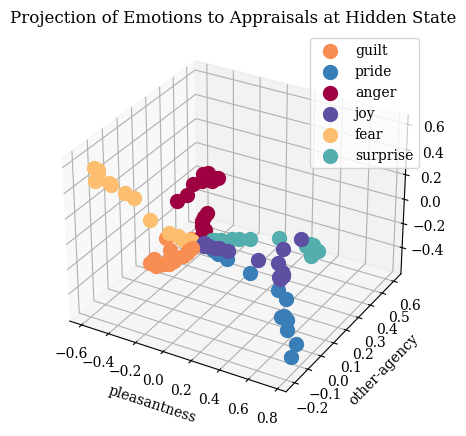

In [30]:
loc_to_focus = 7

appraisals_to_focus = ['pleasantness', 'other_responsblt', 'chance_control']
# appraisals_to_focus = ['pleasantness', 'chance_control']
# appraisals_to_focus = ['chance_control', 'pleasantness']
assert len(appraisals_to_focus) == 3, 'Only three appraisals are supported'

app = appraisal_weights[:, :, [appraisals_to_id[a] for a in appraisals_to_focus]]
app = app[locs_to_probe.index(loc_to_focus)]


emotions_to_focus = ['guilt', 'pride', 'anger', 'joy', 'fear', 'surprise']
emo = emotion_weights[:, :, [emotion_to_id[e] for e in emotions_to_focus]]
emo = emo[locs_to_probe.index(loc_to_focus)]
print(app.shape, emo.shape)

w = torch.einsum('bcd,bed->bce', emo, app)

plt.figure(figsize=(5, 5))
alphas = np.linspace(0.1, 1, layer_count)[::-1]
print(w.shape)
ax = plt.axes(projection='3d')
for i, l in enumerate(range(0, layer_count)):
    for q, e in enumerate(emotions_to_focus):
        if i == 0:
            label = e
        else:
            label = None
        ax.scatter(w[l, q, 0], w[l, q, 1], w[l, q, 2], c=emotion_to_color[e], alpha=1, s=100, label=label)
        # plot text with text alignment center
        # plt.text(w[l, q, 0], w[l, q, 1], f'{l+1}', fontsize=8, ha='center', va='center')

plt.legend()
plt.xlabel(f'{appraisal_to_formal_name_without_newline[appraisals_to_focus[0]]}')
plt.ylabel(f'{appraisal_to_formal_name_without_newline[appraisals_to_focus[1]]}')
plt.title(f'Projection of Emotions to Appraisals at {probe_location_to_formal_name[loc_to_focus]}')  
plt.grid(True)
ax = plt.gca()
ax.set_axisbelow(True)
plt.show()

# Emotion Promotion

In [31]:
def measure_promotion_success(new_preds, emotion_to_promote):
    base_scores = clean_logits.argmax(dim=-1)
    
    e_index = emotion_to_id[emotion_to_promote]
    base_scores = (base_scores == e_index).float().mean(dim=-1)    
    vec = (new_preds == e_index).float().mean(dim=-1)
    delta = (vec - base_scores)
    delta[delta > 0] = delta[delta > 0] / (1 - base_scores)
    delta[delta < 0] = delta[delta < 0] / (base_scores)
    return delta


In [32]:
emotions_to_promote = ['anger', 'fear', 'guilt', 'sadness', 'joy', 'pride', ]
promotion_tokens = [-1] #'all' # 
promotion_locs = [[7]] #[3], [6], 
promotion_locs_ = [p[0] for p in promotion_locs]
Betas = [1.0, 2.0, 4.0,]
Beta2 = 0.0
span = 3
do_normalization = True
layers_centers = list(range(span // 2, layer_count - span // 2))


res_vec = torch.zeros((len(Betas), len(emotions_to_promote), len(promotion_locs), len(layers_centers)))

emo_prob_diff = torch.zeros((len(emotions_to_promote), len(promotion_locs), len(layers_centers)))
app_prob_diff = torch.zeros((len(emotions_to_promote), len(promotion_locs), len(layers_centers)))

for b, Beta1 in enumerate(Betas):
    for e, emotion_to_promote in enumerate(emotions_to_promote):
        for j, locs in enumerate(promotion_locs):
            
            results = torch.load(f'outputs/{model_name}/emotion_promotion/emotion_promotion_{emotion_to_promote}_layers_{layers_centers}_span_{span}_locs_{locs}_tokens_{promotion_tokens}_Beta1_{Beta1}_Beta2_{Beta2}_normalization_{do_normalization}.pt', weights_only=False)
            vec = torch.stack([results[lc] for lc in layers_centers]).argmax(dim=-1)
            res_vec[b, e, j] = measure_promotion_success(vec, emotion_to_promote)
        

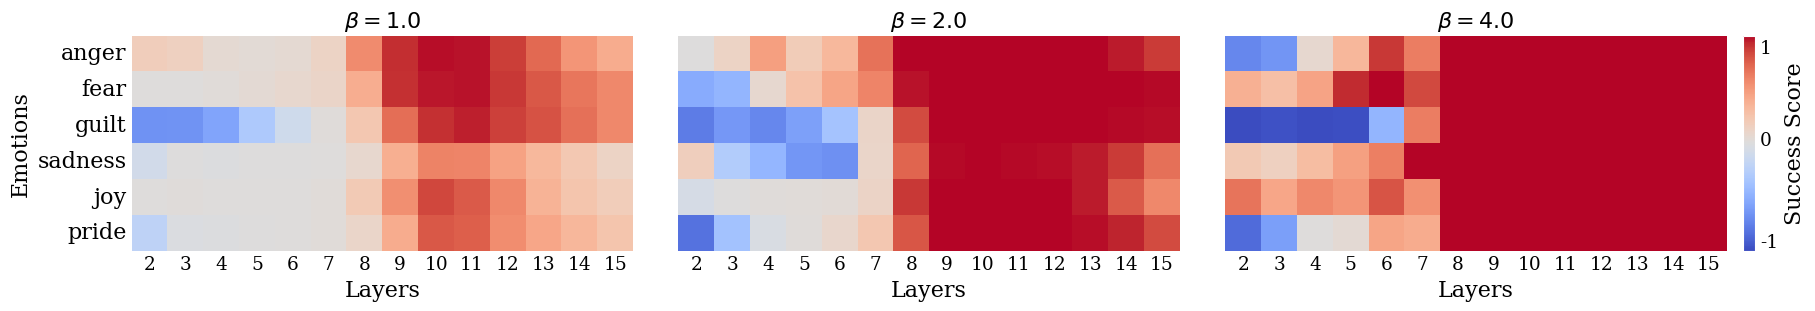

In [33]:
loc_to_plot = 7

plot_heatmap(res_vec[:, :, promotion_locs.index([loc_to_plot])],
             suptitle = f'', titles = [f'$\\beta = {b}$' for b in Betas], fontsize = FONT_SIZE,
             xticks = np.arange(len(layers_centers)) + 0.5, xtick_labels = (torch.tensor(layers_centers) + 1).numpy(),
             yticks = np.arange(len(emotions_to_promote)) + 0.5, ytick_labels = emotions_to_promote,
             yticks_rotation = 0, xticks_rotation = 0,
             vmax=1.0, vmin=-1.0,
             x_axis_label='Layers', y_axis_label='Emotions',
             cmap='coolwarm', cmap_label='Success Score', cmap_shrink=1.0, cmap_aspect=18.0, cmap_fraction=0.01, cmap_pad=0.01,
             cbar_yticks=[-1.0, 0, 0.9], cbar_ytick_labels=[-1, 0, 1],
             figsize=(18, 3), save_path = f'{model_name}/emotion_promotion_heatmap') #

# Appraisal Surgery

In [34]:
surgery_appraisals = [
                        # 
                        
                                                
                        
                        # (['pleasantness'], [], [+1]),  
                        # (['other_responsblt'], [], [+1]),
                        (['pleasantness'], ['predict_event', 'other_responsblt', 'chance_control'], [+1]),
                        (['other_responsblt'], ['predict_event', 'pleasantness', 'chance_control'], [+1]),
                        (['predict_event'], ['pleasantness', 'other_responsblt', 'chance_control'], [+1]),
                        (['chance_control'], ['pleasantness', 'other_responsblt', 'predict_event'], [+1]),

                        # (['pleasantness'], [], [-1]),
                        # (['other_responsblt'], [], [-1]),
                        
                        (['pleasantness'], ['predict_event', 'other_responsblt', 'chance_control'], [-1]),
                        (['other_responsblt'], ['predict_event', 'pleasantness', 'chance_control'], [-1]),
                        (['predict_event'], ['pleasantness', 'other_responsblt', 'chance_control'], [-1]),
                        (['chance_control'], ['pleasantness', 'other_responsblt', 'predict_event'], [-1]),
                        
                        (['pleasantness', 'other_responsblt'], ['predict_event', 'chance_control'], [+1, -1]),
                        (['pleasantness', 'other_responsblt'], ['predict_event', 'chance_control'], [-1, -1]),
                        
                        (['pleasantness', 'other_responsblt'], ['predict_event', 'chance_control'], [+1, +1]),
                        (['pleasantness', 'other_responsblt'], ['predict_event', 'chance_control'], [-1, +1]),
                        
                        (['pleasantness', 'predict_event'], ['other_responsblt', 'chance_control'], [+1, -1]),
                        (['pleasantness', 'predict_event'], ['other_responsblt', 'chance_control'], [-1, -1]),
                        
                        (['pleasantness', 'predict_event'], ['other_responsblt', 'chance_control'], [+1, +1]),
                        (['pleasantness', 'predict_event'], ['other_responsblt', 'chance_control'], [-1, +1]),
                        
                        (['random_42'], [], [+1]),
                        (['random_43'], [], [+1]),
                        (['random_44'], [], [+1]),                        
                        ]



Betas = [1.0, 2.0, 4.0]


promotion_tokens = [-1]
promotion_loc = 7
promotion_locs_ = [p[0] for p in promotion_locs]
Beta2 = 0.0

span = 3
layers_centers = list(range(span // 2, layer_count - span // 2))

do_normalization = True

original_logits = torch.load(f'outputs/{model_name}/original_logits.pt', weights_only=False)
original_labels = original_logits[..., [emotion_to_id[e] for e in emotions_formal]].argmax(dim=-1)
original_emotions = torch.zeros(len(emotions_formal))
for e, emotion in enumerate(emotions_formal):
    original_emotions[e] = (original_labels == e).sum()    

Vs = torch.zeros(len(layers_centers), len(surgery_appraisals), len(Betas), len(emotions_formal))
vecs = torch.zeros(len(layers_centers), len(surgery_appraisals), len(Betas), len(original_labels))

for k, (appraisals_to_change_, appraisals_to_fix_, coeffs_) in enumerate(surgery_appraisals):
    appraisals_to_change = '_'.join(appraisals_to_change_)
    appraisals_to_fix = '_'.join(appraisals_to_fix_)
    coeffs = '_'.join([str(c) for c in coeffs_])
    
    for j, Beta1 in enumerate(Betas):

        results = torch.load(f'outputs/{model_name}/appraisal_surgery/appraisal_surgery_{appraisals_to_change}_fixed_{appraisals_to_fix}_coeffs_{coeffs}_layers_{layers_centers}_span_{span}_locs_{[promotion_loc]}_tokens_{promotion_tokens}_Beta1_{Beta1}_Beta2_{Beta2}_normalization_{do_normalization}.pt', weights_only=False)
        for i, lc in enumerate(layers_centers):
            vec = results[lc]
            vec = vec[..., [emotion_to_id[e] for e in emotions_formal]].argmax(dim=-1)
            vecs[i, k, j] = vec
            
            for e, emotion in enumerate(emotions_formal):
                Vs[i, k, j, e] = (vec == e).sum()

            

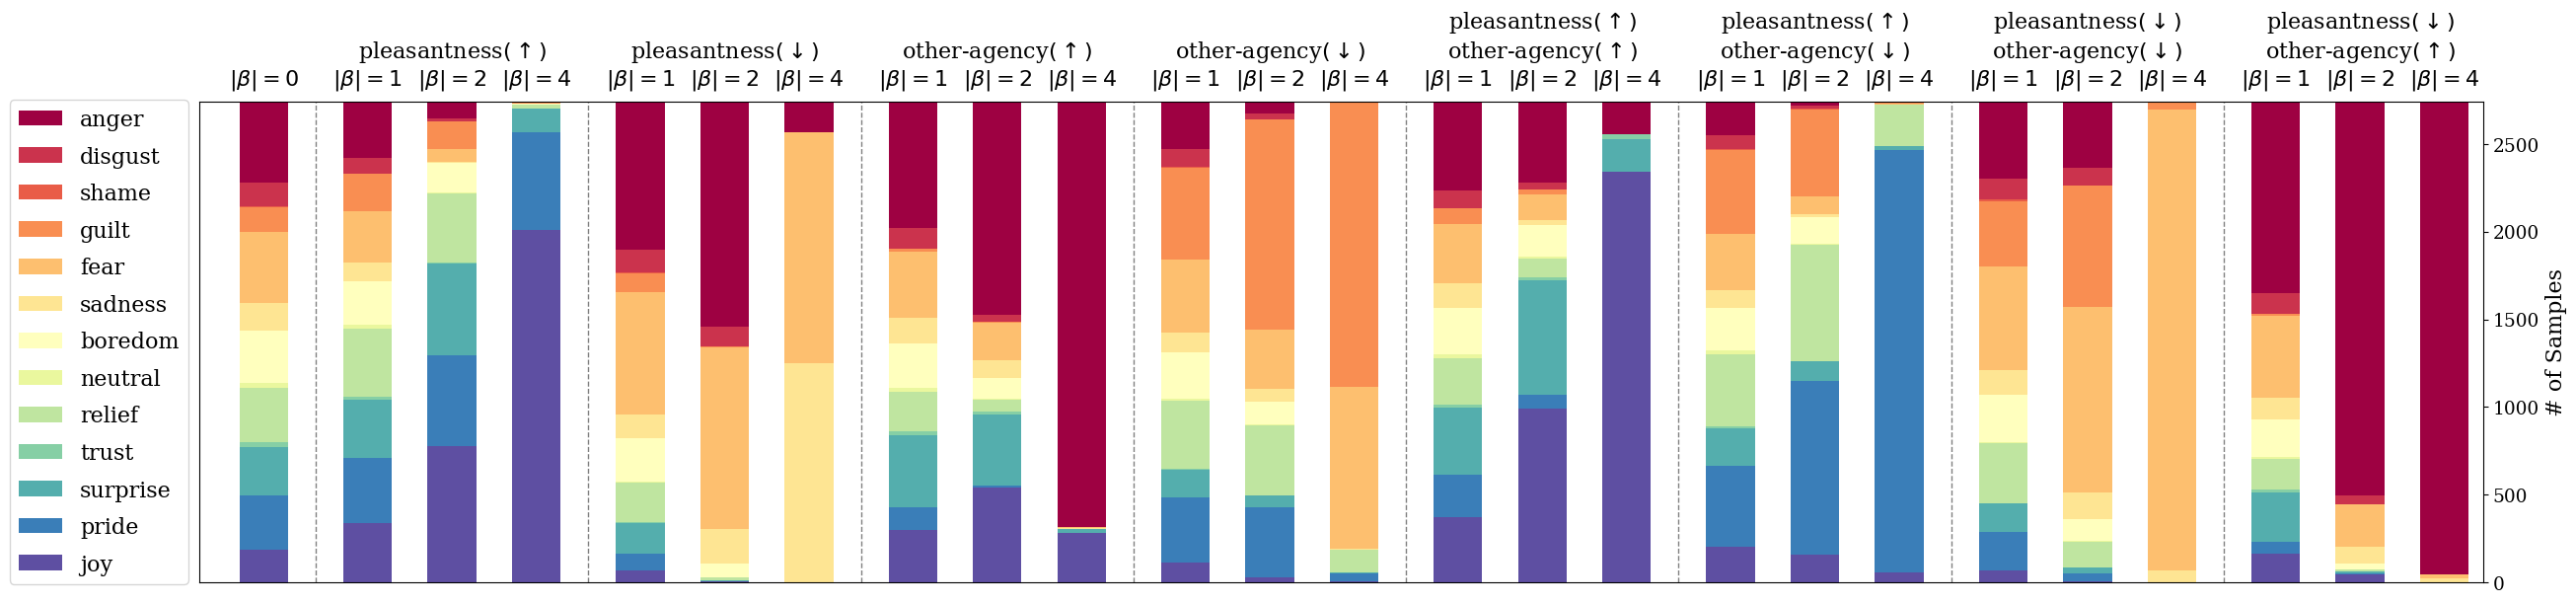

In [35]:
layers_to_pick = [8]
surgery_appraisals_indices_to_pick = [0, 4, 1, 5, 10, 8, 9, 11]
fig, axs = plt.subplots(len(layers_to_pick), 1, figsize=(26, 6), sharex=False, constrained_layout=True)

if len(layers_to_pick) == 1:
    axs = [axs]

for i, lc in enumerate(layers_to_pick):
    x_ticks = []
    x_labels = []
    
    x_counter = 0
    ax = axs[i]
    
    # ax.set_ylabel(f'Layer {lc + 1}', fontsize=FONT_SIZE)
    ax.set_ylabel(f'# of Samples', fontsize=FONT_SIZE)
    for e, emotion in enumerate(emotions_formal):
        ax.bar(x_counter, original_emotions[e], bottom = original_emotions[:e].sum(), label=emotion, color=emotion_to_color[emotion], width=bar_width * 1.5)
    x_ticks.append(x_counter)
    x_labels.append('$|\\beta| = 0$')
    x_counter += 0.65 + 0.15
    ax.vlines(x_counter - (0.65 + 0.15) / 2, 0, original_emotions.sum(), color='gray', linestyle='--', linewidth=1)
    for k, q in enumerate(surgery_appraisals_indices_to_pick):
        (appraisals_to_change_, appraisals_to_fix_, coeffs_) = surgery_appraisals[q]    
    
        for j, Beta1 in enumerate(Betas):
            for e, emotion in enumerate(emotions_formal):
                ax.bar(x_counter, Vs[layers_centers.index(lc), q, j, e], bottom = Vs[layers_centers.index(lc), q, j, :e].sum(), color=emotion_to_color[emotion], width=bar_width * 1.5)
            x_ticks.append(x_counter)
            
            if j == 1:
                appraisals_text = ''
                for _, (a, c) in enumerate(zip(appraisals_to_change_, coeffs_)):
                    arrow = fr'$(\uparrow)$' if c > 0 else r'$(\downarrow)$'
                    
                    appraisals_text += f'{appraisal_to_formal_name_without_newline[a] }{arrow}'
                    appraisals_text += '\n'
                x_labels.append(f'{appraisals_text}$|\\beta|={Beta1:.0f}$')
            else:
                x_labels.append(f'$|\\beta|={Beta1:.0f}$')
            x_counter += 0.65
        x_counter += 0.15
        ax.vlines(x_counter - (0.65 + 0.15) / 2, 0, original_emotions.sum(), color='gray', linestyle='--', linewidth=1)
        
    
    # set y ticks font size
    ax.tick_params(axis='y', labelsize=FONT_SIZE / 1.2)
        
    ax.tick_params(top=False, bottom=False)  # Disable both top and bottom ticks
    ax.yaxis.set_label_position('right') 
    ax.yaxis.tick_right()
    ax.set_xticks([])
    
    ax.set_xlim(-0.5, x_counter - 0.5)

# enable top ticks for x axis
axs[0].set_xticks(x_ticks)
axs[0].set_xticklabels(x_labels, rotation = 0, ha='center', va='bottom', fontsize=FONT_SIZE)
axs[0].xaxis.set_label_position('top')  # Move the label to the top
axs[0].xaxis.tick_top()  # Move the ticks to the top as well (optional)
axs[0].tick_params(top=False, bottom=False)  # Disable both top and bottom ticks

axs[0].legend(loc='center right', bbox_to_anchor=(0, 0.5), labelspacing=.7, fontsize=FONT_SIZE, reverse=True)
plt.savefig(f'figs/{model_name}/app_surgery.pdf', bbox_inches='tight', dpi = 300)

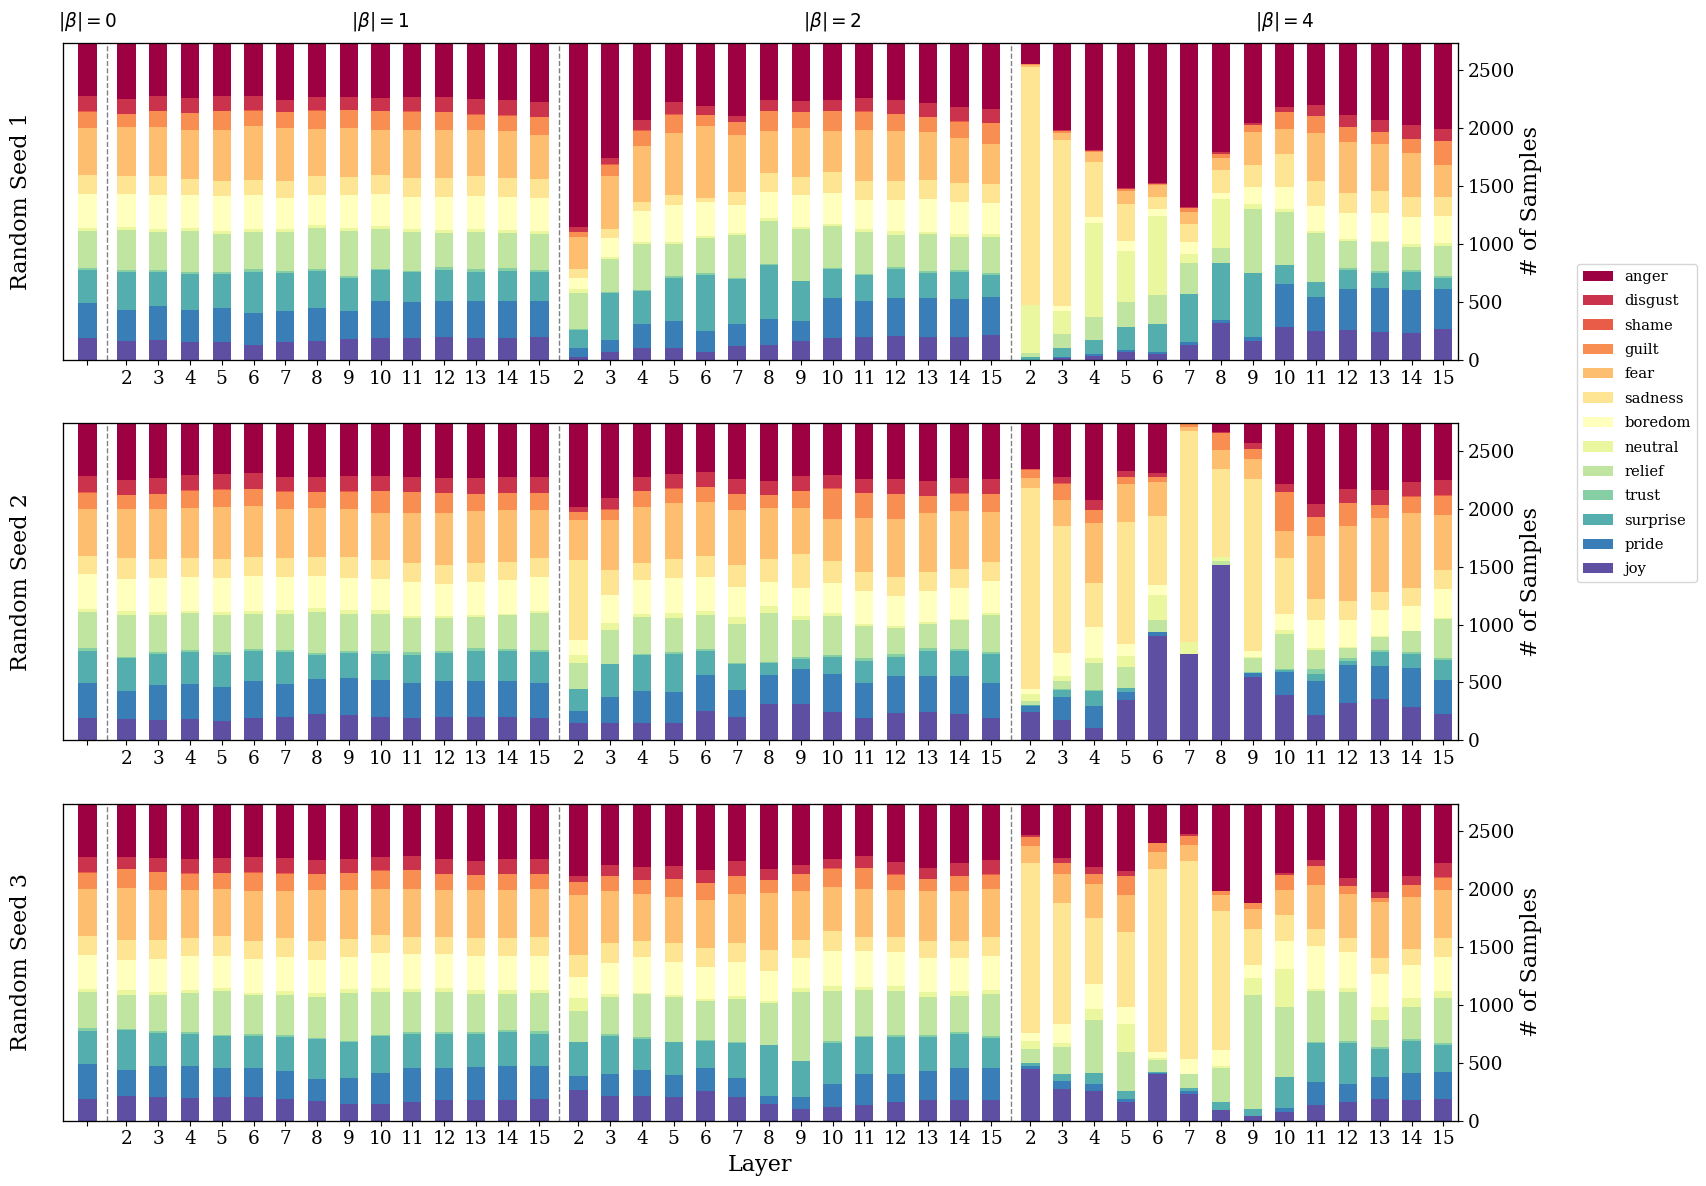

In [39]:
surgery_appraisals_indices_to_pick = [16, 17, 18] #[2, 6] #[1, 5] #[0, 4] #[14, 12, 13, 15] #[10, 8, 9, 11] 

fig, axs = plt.subplots(len(surgery_appraisals_indices_to_pick), 1, figsize=(18, 10  if len(surgery_appraisals_indices_to_pick) == 2 else 14), sharex=False, constrained_layout=False)

if len(surgery_appraisals_indices_to_pick) == 1:
    axs = [axs]

for k, app_id in enumerate(surgery_appraisals_indices_to_pick):
    (appraisals_to_change_, appraisals_to_fix_, coeffs_) = surgery_appraisals[app_id]        

    x_ticks = []
    x_labels_top = []
    x_labels_bottom = []
    
    x_counter = 0
    ax = axs[k]
    
    for e, emotion in enumerate(emotions_formal):
        ax.bar(x_counter, original_emotions[e], bottom = original_emotions[:e].sum(), label=emotion, color=emotion_to_color[emotion], width=bar_width * 1.5)
    x_ticks.append(x_counter)
    x_labels_top.append('$|\\beta| = 0$')
    x_labels_bottom.append('')
    x_counter += 0.65 + 0.15
    ax.vlines(x_counter - (0.65 + 0.15) / 2, 0, original_emotions.sum(), color='gray', linestyle='--', linewidth=1)

    
    for j, Beta1 in enumerate(Betas):
        for i, lc in enumerate(layers_centers):
            for e, emotion in enumerate(emotions_formal):
                ax.bar(x_counter, Vs[layers_centers.index(lc), app_id, j, e], bottom = Vs[layers_centers.index(lc), app_id, j, :e].sum(), color=emotion_to_color[emotion], width=bar_width * 1.5)
            x_ticks.append(x_counter)
            
            if i == len(layers_centers) // 2 + 1:
                x_labels_top.append(f'$|\\beta|={Beta1:.0f}$')
            else:
                x_labels_top.append('')
            x_labels_bottom.append(lc + 1)
            x_counter += 0.65
        x_counter += 0.15
        ax.vlines(x_counter - (0.65 + 0.15) / 2, 0, original_emotions.sum(), color='gray', linestyle='--', linewidth=1)
    
    
    
    appraisal_text = ''
    for q, (a, c) in enumerate(zip(appraisals_to_change_, coeffs_)):
        arrow = fr'$(\uparrow)$' if c > 0 else r'$(\downarrow)$'
        if a.startswith('random'):
            appraisal_text += f'Random Seed {int(a.split("_")[1]) - 41}'
        else:
            appraisal_text += f'{appraisal_to_formal_name_without_newline[a] }{arrow}'
        appraisal_text += '\n'
        
    ax2 = ax.twinx()
    ax2.set_ylabel(f'{appraisal_text}', fontsize=FONT_SIZE)
    ax2.set_yticks([])
    ax2.yaxis.set_label_position('left')
    
    ax.set_ylabel(f'# of Samples', fontsize=FONT_SIZE)
    ax.tick_params(axis='y', labelsize=FONT_SIZE / 1.2)
    ax.tick_params(top=False, bottom=False)  # Disable both top and bottom ticks
    ax.yaxis.set_label_position('right') 
    ax.yaxis.tick_right()
    ax.set_ylim(0, original_emotions.sum())
    ax.set_xlim(-0.5, x_counter - 0.5)
    ax2 = ax.twiny()
    ax2.xaxis.set_label_position('bottom')
    ax2.set_xticks(x_ticks)
    ax2.set_xticklabels(x_labels_bottom, rotation = 0, ha='center', va='top', fontsize=FONT_SIZE / 1.2)
    ax2.tick_params(top=False, bottom=False)
    ax2.xaxis.tick_bottom()
    ax2.set_xlim(-0.5, x_counter - 0.5)    
    if k == len(surgery_appraisals_indices_to_pick) - 1:
        ax2.set_xlabel('Layer', fontsize=FONT_SIZE)
        
    if k == 0:
        ax.xaxis.set_label_position('top')
        ax.xaxis.tick_top()
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels_top, rotation = 0, ha='center', va='bottom', fontsize=FONT_SIZE / 1.2)
        ax.tick_params(top=False, bottom=False)  # Disable both top and bottom ticks
    else:
        ax.set_xticks([])

axs[1].legend(loc='center left', bbox_to_anchor=(+1.08, 1.), labelspacing=.7, fontsize=FONT_SIZE/1.5, reverse=True)
plt.savefig(f'figs/{model_name}/app_surgery_{appraisals_to_change_}.pdf', bbox_inches='tight', dpi = 300)                
            


pleasantness$(\uparrow)$

pleasantness$(\downarrow)$



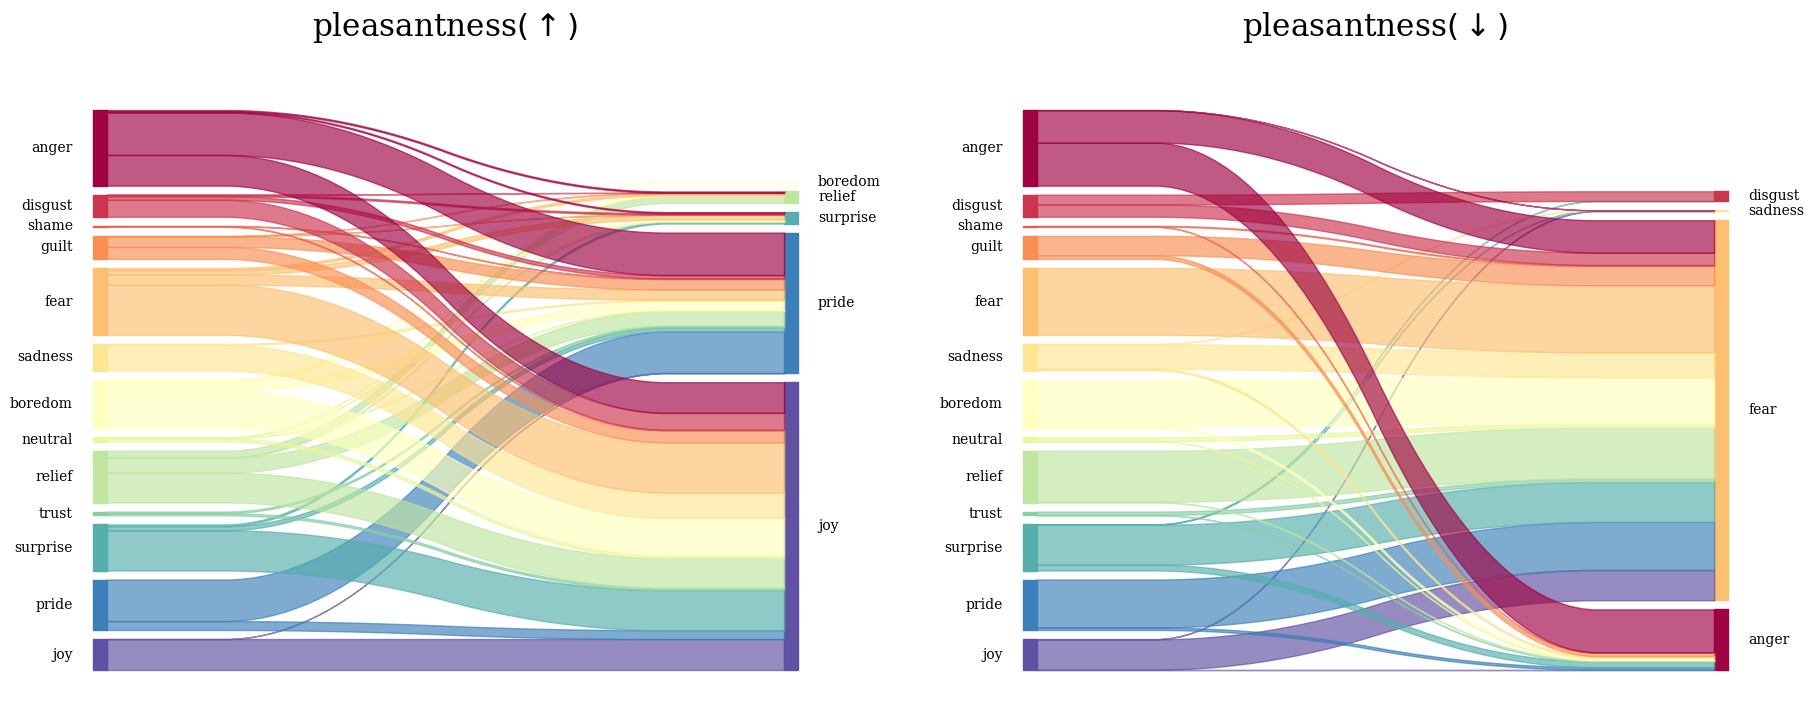

In [56]:
from my_sankey import sankey

lc = 9
surgery_appraisals_indices_to_pick = [0, 4]
beta = 4.0
fig, axs = plt.subplots(1, len(surgery_appraisals_indices_to_pick), figsize=(22, 8), constrained_layout=False)
if len(surgery_appraisals_indices_to_pick) == 1:
    axs = [axs]

for k, q in enumerate(surgery_appraisals_indices_to_pick):
    ax = axs[k]

    data_modified = vecs[layers_centers.index(lc), q, Betas.index(beta)]
    data_modified = [emotions_formal[int(i.item())] for i in data_modified]
    
    data_clean = original_labels
    data_clean = [emotions_formal[i.item()] for i in data_clean]
    

    data_clean, data_modified = sort_two_emotion_lists_based_on_the_first_one(data_clean, data_modified, emotions_formal)

    sankey(ax, data_clean, data_modified, aspect = 200, fontsize=10, colorDict = emotion_to_color)
    
    appraisal_text = ''
    (appraisals_to_change_, appraisals_to_fix_, coeffs_) = surgery_appraisals[q]
    for _, (a, c) in enumerate(zip(appraisals_to_change_, coeffs_)):
        arrow = fr'$(\uparrow)$' if c > 0 else r'$(\downarrow)$'
        appraisal_text += f'{appraisal_to_formal_name_without_newline[a] }{arrow}'
        appraisal_text += '\n'
    print(appraisal_text)
    ax.set_title(f'{appraisal_text}', fontsize=FONT_SIZE * 1.4)
    

plt.savefig(f'figs/{model_name}/app_surgery_sankey_{appraisals_to_change_}.pdf', bbox_inches='tight', dpi = 300)
plt.show()
